In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.offsetbox import AnchoredText

from scipy.stats import bootstrap #Need Scipy 1.8.0

In [2]:
#For formatting for interation.yamls
def MatrixString(matrix):
    string = "["
    for i in range(matrix.shape[0]):
        string += "["
        for j in range(matrix.shape[1]):
            string += "%.2f" % matrix[i,j]
            if j < matrix.shape[1]-1:
                string+=","
        string+="]"
        if i < matrix.shape[0]-1:
                string+=","
    string+="]"
    return string

def PolicyText(Type, contacts, contacts_err, proportional_physical, characteristic_time):
    print("  %s:" % Type)
    print("    contacts: %s" % MatrixString(contacts))
    print("    contacts_err: %s" % MatrixString(contacts_err))
    print("    proportion_physical: %s" % MatrixString(proportional_physical))
    print("    characteristic_time: %.2f" % characteristic_time)

In [3]:
data_file = "../Downloaded_Items/UNHCR BGD 2020 Protection Measures COVID 19.csv"

In [4]:
data = pd.read_csv(data_file)
NPop = np.array([295901,274933]) #N children N Adults

In [5]:
#Loop over all possible time spent answers to create list.
TimeCols = ["education_time", "education_time77", 'distcenter_time',
       'distcenter_time77', 'evoucher_time', 'evoucher_time77','community_time', 'community_time77', 'religious_time', 'religious_time_77','pump_time',
       'pump_time77']
AllTimeAnswers=[]
for whichtime in TimeCols:
    Key, _ = np.unique(data[whichtime].dropna(), return_counts=True)
    AllTimeAnswers += list(Key)
    
KeysAll = list(set(AllTimeAnswers))
#Print with correct formatting for look-up dictionary
for i in KeysAll:
    print("'%s' : ," % i) 

'3 hrs' : ,
'30 to 45 min' : ,
'30 mnt' : ,
'12minutes' : ,
'15 minutes ' : ,
'20 minutes ' : ,
'35 minutes ' : ,
'20minit' : ,
'20min' : ,
'3 hour ' : ,
'2 hour ' : ,
'1 hour and 30 minutes' : ,
'half an hour' : ,
'30 minutes' : ,
'30 min' : ,
'24' : ,
'30minutes' : ,
'4' : ,
'3â€“5 minutes ' : ,
'34minutes' : ,
'3 to 5 min' : ,
'40 minutes ' : ,
'2.5 hours' : ,
'10 Minutes' : ,
'25 minute' : ,
'other' : ,
'10 minutes' : ,
'30min' : ,
'15sec' : ,
'Half an hour.' : ,
'12 minutes ' : ,
'30mins water pumps and 15mins in latrine' : ,
'10  minutes ' : ,
'3min' : ,
'50 minutes ' : ,
'15' : ,
'4 hour' : ,
'20 min' : ,
'15min' : ,
'Need  Other help ' : ,
'29 minutes' : ,
'Need  Other  help' : ,
'2 hours' : ,
'4 hour ' : ,
'She do not go to water pump because she has a son.' : ,
'10 minute' : ,
'15 minutes' : ,
'Half an hour' : ,
'25 minutes' : ,
'5 minutes' : ,
'30mins in water pumps and 15min in latrine' : ,
'35 minute ' : ,
'15minutes' : ,
'20mins in water pump and 15min in latrine' : ,
'5 

In [6]:
#Manually add keys for these!
TimeDict = {  
    np.nan : np.nan,
    '15 minutes' : 15,
    '12 minutes ' : 12,
    '3min' : 3,
    '30mins' : 30,
    '25mi' : 25,
    '5 to 10' : 7.5,
    'other' : np.nan,
    '40 minutes' : 40,
    'Half an hour' : 30,
    '5 to 10 min' : 7.5,
    '3o minutes' : 30,
    '25min' : 25,
    '30 Min' : 30,
    '15 minute' : 15,
    '5 minutes' : 5,
    '30 minute ' : 30,
    'Need  Other help ' : np.nan,
    '10 to 15 minutes ' : 12.5,
    '30 to 45 min' : 37.5,
    '24' : 24,
    '12minutes' : 12,
    '2.5 hours' : 2.5*60,
    '40mnt' : 40,
    '10 minutes' : 10,
    '0 minutes' : np.nan,
    'Need  Other  help' : np.nan,
    '10 minutes ' : 10,
    '35 minutes ' : 35,
    '40min' : 40,
    '5 Minutes' : 5,
    '30 Minutes ' : 30,
    '20 minute ' : 20,
    '30 mnt' : 30,
    '4 hour ' : 4*60,
    '20min' : 20,
    '2 to 3 min' : 2.5,
    '50min' : 50,
    '15sec' : np.nan,
    '29minutes' : 29,
    '30' : 30,
    '15 minutes ' : 15,
    '3 hrs' : 3*60,
    '17 minutes' : 17,
    '30 minutes ' : 30,
    '10  minutes ' : 10,
    '29 minutes' : 29,
    '20minit' : 20,
    '3 to 5 min' : 4,
    '7 minutes' : 7,
    '4 hour' : 4*60,
    '30mins in water pumps and 15min in latrine' : 45,
    '35minutes' : 35,
    '30minutes' : 30,
    '20 Minutes ' : 20,
    '10 Minutes' : 10,
    '50 minutes ' : 50,
    '25 minute' : 25,
    '40 minutes ' : 40,
    '15mins' : 15,
    '18 minutes ' : 18,
    '15 minute ' : 15,
    'She do not go to water pump because she has a son.' : np.nan,
    '20' : 20,
    '35 minute ' : 35,
    '45minutes' : 45,
    '1 hour and 30 minutes' : 1.5*60,
    '12 minutes' : 12,
    '15minutes' : 15,
    '5 minute' : 5,
    '3 hour ' : 3*60,
    '25 minutes' : 25,
    '30mins in water pumps and 15mins in latrin' : 45,
    '3 hours' : 3*60,
    '20/30minutes' : 25,
    '30 min' : 30,
    '1 hour' : 1*60,
    '10 min' : 10,
    '30min' : 30,
    '23' : 23,
    '2 to 3 min ' : 2.5,
    '2 minutes' : 2,
    '10 to 20 min' : 15,
    '20 minutes ' : 20,
    '34minutes' : 34,
    '45' : 45,
    '30 minutes' : 30,
    '3â€“5 minutes ' : 5,
    'half an hour ' : 30,
    '30mins water pumps and 15mins in latrine' : 45,
    '2 hours' : 2*60,
    '15min' : 15,
    'half an hour' : 30,
    '20mins in water pump and 15min in latrine' : 35,
    '20minutes' : 20,
    '4' : np.nan, #Minutes/hours?
    '4 hours' : 4*60,
    '10minutes' : 10,
    '20 min' : 20,
    '40minutes' : 40,
    '25 minutes ' : 25,
    '45 min' : 45,
    '15' : 15,
    '20 to 25 minutes ' : 22.5,
    'Half an hour.' : 30,
    '10 minute' : 10,
    '10' : 10,
    '2 hour ' : 2*60,
    '20 minutes' : 20
}

In [7]:
def child_child(data, x):
    Indexes = data["age"] == "Under 18"
    return (data[Indexes][x]).values, Indexes.values
    
def adult_adult(data, x):
    Indexes = data["age"].isin(["Over 18 but under 60", "Over 60"])
    return (data[Indexes][x]).values, Indexes
    
def child_adult(data, x):
    Indexes = data["age"] == "Under 18"
    return (data[Indexes][x]).values, Indexes
    
def adult_child(data, x):
    Indexes = data["age"].isin(["Over 18 but under 60", "Over 60"])
    return (data[Indexes][x]).values, Indexes

In [8]:
def contact_matrix_error(matrix, metric=np.median, confidence_level=0.682689492137086):
    Error = np.zeros_like(matrix)
    
    for i in range(Error.shape[0]):
        for j in range(Error.shape[0]):
        
            res = bootstrap(
                (matrix[i,j],), 
                metric,  
                vectorized=False, 
                confidence_level=confidence_level,
                random_state=None, 
                method="percentile"
            )
            #print(res.confidence_interval)
            Error[i,j] = res.standard_error
    return Error
    

In [9]:

def contact_matrix(data, x, y, times, norm=False, characteristic_time=1):
    c_c, T_cc = child_child(data, x)
    timesgiven_cc = times[T_cc]
    naninf = (np.isnan(c_c) | np.isinf(c_c) | np.isnan(timesgiven_cc) | np.isinf(timesgiven_cc))
    c_c = c_c[~naninf]
    timesgiven_cc = timesgiven_cc[~naninf]
    
    c_a, T_ca = child_adult(data, y)
    timesgiven_ca = times[T_ca]
    naninf = (np.isnan(c_a) | np.isinf(c_a) | np.isnan(timesgiven_ca) | np.isinf(timesgiven_ca))
    c_a = c_a[~naninf]
    timesgiven_ca = timesgiven_ca[~naninf]
    
    a_a, T_aa = adult_adult(data, y)
    timesgiven_aa = times[T_aa]
    naninf = (np.isnan(a_a) | np.isinf(a_a) | np.isnan(timesgiven_aa) | np.isinf(timesgiven_aa))
    a_a = a_a[~naninf]
    timesgiven_aa = timesgiven_aa[~naninf]
    
    a_c, T_ac = adult_child(data, x)
    timesgiven_ac = times[T_ac]
    naninf = (np.isnan(a_c) | np.isinf(a_c) | np.isnan(timesgiven_ac) | np.isinf(timesgiven_ac))
    a_c = a_c[~naninf]
    timesgiven_ac = timesgiven_ac[~naninf]
    

    if norm == True:
        fig, axes = plt.subplots(2,2)
        corr, _ = pearsonr(c_c, timesgiven_cc)
        at = AnchoredText('Pearsons corr: %.2f' % corr, frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[0,0].add_artist(at)
        axes[0,0].scatter(c_c, timesgiven_cc)
        axes[0,0].set_title("c_c")
        
        corr, _ = pearsonr(c_a, timesgiven_ca)
        at = AnchoredText('Pearsons corr: %.2f' % corr, frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[0,1].add_artist(at)
        axes[0,1].scatter(c_a, timesgiven_ca)
        axes[0,1].set_title("c_a")
        
        corr, _ = pearsonr(a_c, timesgiven_ac)
        at = AnchoredText('Pearsons corr: %.2f' % corr, frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[1,0].add_artist(at)
        axes[1,0].scatter(a_c, timesgiven_ac)
        axes[1,0].set_title("a_c")
        
        corr, _ = pearsonr(a_a, timesgiven_aa)
        at = AnchoredText('Pearsons corr: %.2f' % corr, frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[1,1].add_artist(at)
        axes[1,1].scatter(a_a, timesgiven_aa)
        axes[1,1].set_title("a_a")

        axes[0,0].set_xlabel("N contacts")
        axes[0,1].set_xlabel("N contacts")
        axes[1,0].set_xlabel("N contacts")
        axes[1,1].set_xlabel("N contacts")
        axes[0,0].set_ylabel("time (mins)")
        axes[0,1].set_ylabel("time (mins)")
        axes[1,0].set_ylabel("time (mins)")
        axes[1,1].set_ylabel("time (mins)")
        
        plt.tight_layout()
        plt.show()
    
        #Normalize over contacts for the median time spend there.
        c_c /= (timesgiven_cc/characteristic_time) 
        c_a /= (timesgiven_ca/characteristic_time)
        a_a /= (timesgiven_aa/characteristic_time)
        a_c /= (timesgiven_ac/characteristic_time)
        
    maxcontacts = max(max(c_c),max(c_a),max(a_c),max(a_a))
    maxcontacts = (maxcontacts - (maxcontacts%10))+10
    if maxcontacts > 40:
        maxcontacts = 40
        
    bins = np.arange(0,maxcontacts+1,1)-0.5
    fig, axes = plt.subplots(2,2)
    axes[0,0].hist(c_c, bins)
    axes[0,0].set_title("c_c")
    axes[0,1].hist(c_a, bins)
    axes[0,1].set_title("c_a")
    axes[1,0].hist(a_c, bins)
    axes[1,0].set_title("a_c")
    axes[1,1].hist(a_a, bins)
    axes[1,1].set_title("a_a")
    
    axes[0,0].set_xlabel("N contacts")
    axes[0,1].set_xlabel("N contacts")
    axes[1,0].set_xlabel("N contacts")
    axes[1,1].set_xlabel("N contacts")
    
    axes[0,0].set_ylabel("counts")
    axes[0,1].set_ylabel("counts")
    axes[1,0].set_ylabel("counts")
    axes[1,1].set_ylabel("counts")
    
    plt.tight_layout()
    plt.show()

    Array = np.array([[np.nanmedian(c_c),np.nanmedian(c_a)],[np.nanmedian(a_c),np.nanmedian(a_a)]])
    Error = contact_matrix_error(np.array([[c_c, c_a],[a_c ,a_a]],dtype=object))
    return Array, Error

In [10]:
def ModifyCM(input_cm, input_err, NSurvey):
    Gij = np.zeros_like(input_cm)
    Gij_err = np.zeros_like(input_err)
    
    for i in range(Gij.shape[0]):
        for j in range(Gij.shape[1]):
            Gij[i,j] = input_cm[i,j]*(sum(NPop)/sum(NSurvey))*(NSurvey[j]/NPop[j])
            Gij_err[i,j] = input_err[i,j]*(sum(NPop)/sum(NSurvey))*(NSurvey[j]/NPop[j])
    return Gij,Gij_err

In [11]:
def GetBetterTimes(data, Cols):
    Times = []
    for row_i in range(data.shape[0]):
        T1 = data[Cols].iloc[row_i].values[0]
        T2 = data[Cols].iloc[row_i].values[1]
        
        T1_Trans = TimeDict[T1]
        T2_Trans = TimeDict[T2]
                
        if np.isnan(T1_Trans) == False:
            Times.append(T1_Trans)
        elif np.isnan(T2_Trans) == False:
            Times.append(T2_Trans)
        else:
            Times.append(np.nan)  
    return Times

def attendance(times):
    main_times, main_counts = np.unique(times, return_counts=True)

    df = pd.DataFrame({'times': list(main_times), 'counts': list(main_counts)}).groupby('times').sum()
    times = list(df.index)
    counts = list(df.counts)
    
    plt.hist(times, bins=np.arange(0,4*60,10))
    plt.xlabel("time (mins)")
    plt.ylabel("counts")
    plt.show()
    
    assert len(times) == len(counts)
    counts = np.array(counts)
    times = np.array(times)
    total = []
    for idx, i in enumerate(counts):
        for j in range(i):
            total.append(float(times[idx]))
    return np.mean(total), np.median(total)

## Overview

In [12]:
print ("There are {} participants".format(len(data)))
#print(data.columns)

There are 309 participants


In [13]:
np.unique(data["sex"].dropna(), return_counts=True)

(array(['Female', 'Male'], dtype=object), array([152, 155]))

In [14]:
Nij = np.unique(data["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([115, 102,  92]))
[ 92 217]


In [15]:
np.unique(data["disability"], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([261,  48]))

## Face mask

In [16]:
#"Do you have access to a face mask?"

In [17]:
np.unique(data["face_mask"], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([ 58, 251]))

In [18]:
np.unique(data[data["face_mask"] == "No"]["sex"], return_counts=True)

(array(['Female', 'Male'], dtype=object), array([31, 27]))

In [19]:
Nij = np.unique(data[data["face_mask"] == "No"]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([15, 26, 17]))
[17 41]


In [20]:
np.unique(data[data["face_mask"] == "No"]["disability"], return_counts=True)
## Note: need to scale

(array(['No', 'Yes'], dtype=object), array([45, 13]))

## Learning centers

In [21]:
#"When the learning centers were open, did you attend any formal education?"

In [22]:
np.unique(data["education"], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([193, 116]))

In [23]:
Nij = np.unique(data[(data["education"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([22,  3, 37]))
[37 25]


In [24]:
Nij=np.unique(data[(data["education"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([13,  4, 35]))
[35 17]


In [25]:
Nij=np.unique(data[(data["education"] == "Yes")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([35,  7, 74]))
[74 42]


In [26]:
np.unique(data[data["education"] == "Yes"]["disability"], return_counts=True)
## Note: need to scale

(array(['No', 'Yes'], dtype=object), array([108,   8]))

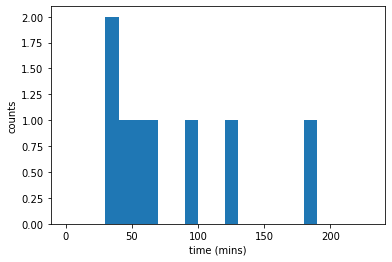

In [27]:
#When you go to an learning center, how much time do you spend there?
times = GetBetterTimes(data,["education_time","education_time77" ])
lc_attendance_mean, lc_attendance_median = attendance(times)

In [28]:
lc_attendance_mean/60., lc_attendance_median/60.

(1.496312684365782, 1.5)

Average over answers


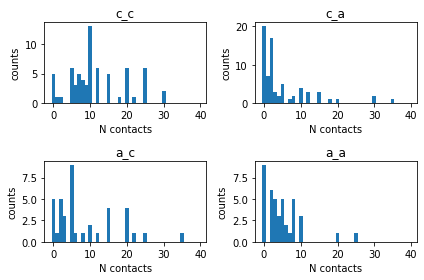

  learning_center:
    contacts: [[12.31,1.50],[6.15,3.01]]
    contacts_err: [[0.86,0.18],[2.10,0.65]]
    proportion_physical: [[0.12,0.12],[0.12,0.12]]
    characteristic_time: 1.50

Average over answers per unit time


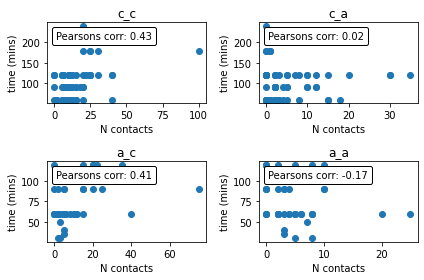

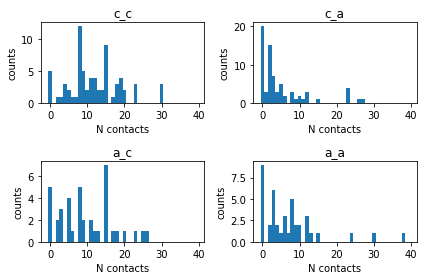

  learning_center:
    contacts: [[13.38,1.50],[11.08,4.51]]
    contacts_err: [[1.53,0.39],[2.68,1.11]]
    proportion_physical: [[0.12,0.12],[0.12,0.12]]
    characteristic_time: 1.50


In [29]:
#"When you attended formal education, approximately how many children do you come into contact with (for example, talk to)?"
#"When you attended formal education, approximately how many adults do you come into contact with (for example, talk to)?"
print("Average over answers")
lc_contact, lc_error = contact_matrix(
    data = data,
    x = "education_contact_children",
    y = "education_contact_adults",
    times = np.array(times)
)
lc_contact, lc_error = ModifyCM(lc_contact, lc_error, Nij)
PolicyText("learning_center", lc_contact, lc_error, np.array([[0.12,0.12],[0.12,0.12]]), lc_attendance_median/60.)

print("")
print("Average over answers per unit time")
lc_contact, lc_error = contact_matrix(
    data = data,
    x = "education_contact_children",
    y = "education_contact_adults",
    times = np.array(times),
    norm = True, characteristic_time=lc_attendance_median
)
lc_contact, lc_error = ModifyCM(lc_contact, lc_error, Nij)
PolicyText("learning_center", lc_contact, lc_error, np.array([[0.12,0.12],[0.12,0.12]]), lc_attendance_median/60.)


## Food distribution center

In [30]:
#"Do you ever go to a food distribution center?"
Nij=np.unique(data[(data["distcenter"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([54, 29, 14]))
[14 83]


In [31]:
Nij=np.unique(data[(data["distcenter"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([33, 20,  5]))
[ 5 53]


In [32]:
Nij=np.unique(data[(data["distcenter"] == "Yes") ]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([87, 49, 20]))
[ 20 136]


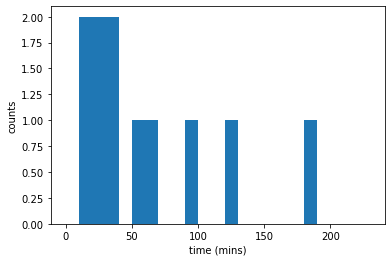

In [33]:
#When you go to a food distribution center, how much time do you spend there?
times = GetBetterTimes(data,["distcenter_time","distcenter_time77" ])
dc_attendance_mean, dc_attendance_median = attendance(times)

In [34]:
dc_attendance_mean/60., dc_attendance_median/60.

(1.1765350877192982, 1.0)

Average over answers


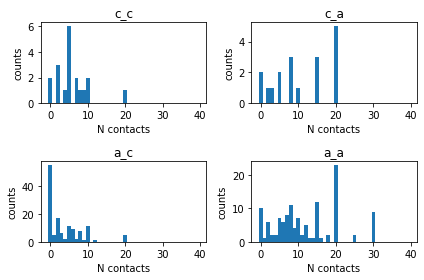

  distribution_center:
    contacts: [[1.24,18.10],[0.49,21.72]]
    contacts_err: [[0.20,6.89],[0.12,3.16]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00

Average over answers per unit time


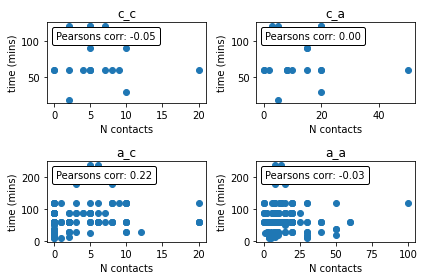

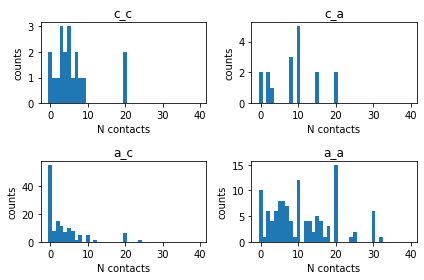

  distribution_center:
    contacts: [[1.24,18.10],[0.49,18.10]]
    contacts_err: [[0.24,3.04],[0.12,2.93]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00


In [35]:
#"When you go to a food distribution center, approximately how many children do you come into contact with at the center (for example, talk to)?",
#"When you go to a food distribution center, approximately how many adults do you come into contact with at the center (for example, talk to)?"
print("Average over answers")
dc_contact, dc_error = contact_matrix(
    data = data,
    x = "distcenter_contact_children",
    y = "distcenter_contact_adults",
    times = np.array(times)
)
dc_contact, dc_error = ModifyCM(dc_contact, dc_error, Nij)
PolicyText("distribution_center", dc_contact, dc_error, np.array([[0.12]]), dc_attendance_median/60.)

print("")
print("Average over answers per unit time")

dc_contact, dc_error = contact_matrix(
    data = data,
    x = "distcenter_contact_children",
    y = "distcenter_contact_adults",
    times = np.array(times),
    norm = True, characteristic_time=dc_attendance_median
)

dc_contact, dc_error = ModifyCM(dc_contact, dc_error, Nij)
PolicyText("distribution_center", dc_contact, dc_error, np.array([[0.12]]), dc_attendance_median/60.)

## E-voucher outlet

In [36]:
#Do you ever go to an e-voucher outlet?
Nij=np.unique(data[(data["evoucher"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([41, 22,  8]))
[ 8 63]


In [37]:
Nij=np.unique(data[(data["evoucher"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([24, 16,  5]))
[ 5 40]


In [38]:
Nij=np.unique(data[(data["evoucher"] == "Yes")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([65, 38, 13]))
[ 13 103]


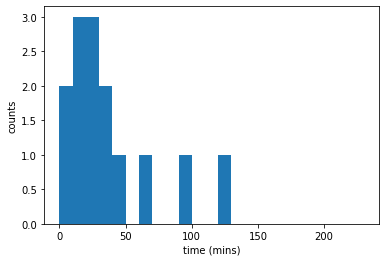

In [39]:
#When you go to a e-voucher outlet, how much time do you spend there?
times = GetBetterTimes(data,["evoucher_time","evoucher_time77" ])
voucher_attendance_mean, voucher_attendance_median = attendance(times)

In [40]:
voucher_attendance_mean/60., voucher_attendance_median/60.

(0.7507788161993769, 1.0)

Average over answers


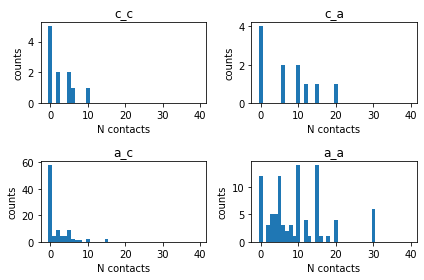

  e_voucher:
    contacts: [[0.43,11.06],[0.00,18.44]]
    contacts_err: [[0.38,6.71],[0.03,2.28]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00

Average over answers per unit time


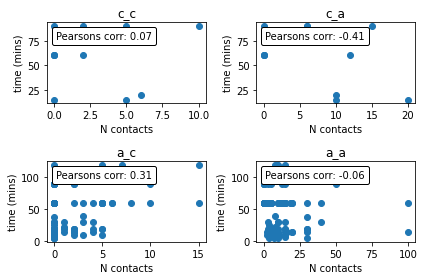

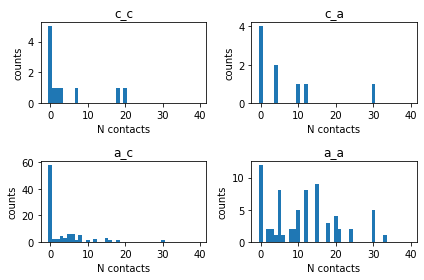

  e_voucher:
    contacts: [[0.29,7.37],[0.00,27.65]]
    contacts_err: [[0.46,12.89],[0.05,3.94]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00


In [41]:
#"When you go to an outlet, approximately how many children do you come into contact with at the outlet (for example, talk to)?",
#"When you go to an outlet, approximately how many adults do you come into contact with at the outlet (for example, talk to)?",
print("Average over answers")
voucher_contact, voucher_error = contact_matrix(
    data = data,
    x = "evoucher_contact_children",
    y = "evoucher_contact_adults",
    times = np.array(times)
)
voucher_contact, voucher_error = ModifyCM(voucher_contact, voucher_error , Nij)
PolicyText("e_voucher", voucher_contact, voucher_error, np.array([[0.12]]), voucher_attendance_median/60.)

print("")
print("Average over answers per unit time")
voucher_contact, voucher_error = contact_matrix(
    data = data,
    x = "evoucher_contact_children",
    y = "evoucher_contact_adults",
    times = np.array(times),
    norm = True, characteristic_time=voucher_attendance_median
)
voucher_contact, voucher_error = ModifyCM(voucher_contact, voucher_error , Nij)
PolicyText("e_voucher", voucher_contact, voucher_error, np.array([[0.12]]), voucher_attendance_median/60.)

## Community center

In [42]:
#Do you ever go to a community center?
Nij=np.unique(data[(data["community"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([41, 25, 33]))
[33 66]


In [43]:
Nij=np.unique(data[(data["community"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([32, 27, 27]))
[27 59]


In [44]:
Nij=np.unique(data[(data["community"] == "Yes") ]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([73, 52, 60]))
[ 60 125]


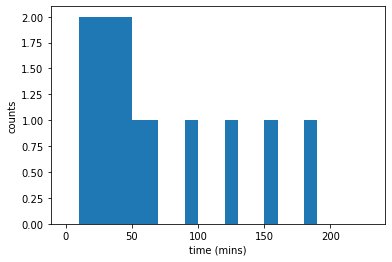

In [45]:
#When you go to a community center, how much time do you spend there?
times = GetBetterTimes(data,["community_time","community_time77" ])
community_attendance_mean, community_attendance_median = attendance(times)

In [46]:
community_attendance_mean/60., community_attendance_median/60.

(1.249099099099099, 1.0)

Average over answers


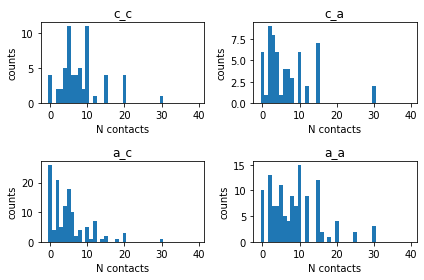

  communal:
    contacts: [[4.38,6.31],[2.50,11.22]]
    contacts_err: [[0.59,1.61],[0.37,1.13]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00
  female_communal:
    contacts: [[4.38,6.31],[2.50,11.22]]
    contacts_err: [[0.59,1.61],[0.37,1.13]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00

Average over answers per unit time


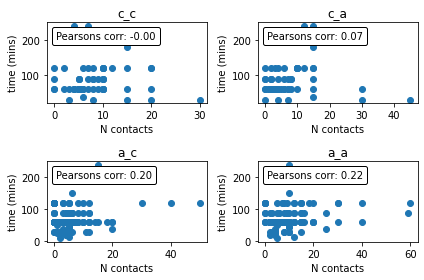

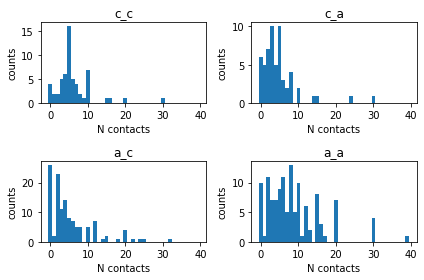

  communal:
    contacts: [[3.13,5.61],[2.35,10.52]]
    contacts_err: [[0.19,0.95],[0.32,0.98]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00
  female_communal:
    contacts: [[3.13,5.61],[2.35,10.52]]
    contacts_err: [[0.19,0.95],[0.32,0.98]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00


In [47]:
#"When you go to a community center, approximately how many children do you come into contact with at the center (for example, talk to)?",
#"When you go to a community center, approximately how many adults do you come into contact with at the center (for example, talk to)?"
print("Average over answers")
community_contact, community_error = contact_matrix(
    data = data,
    x = "community_contact_children",
    y = "community_contact_adults",
    times = np.array(times)
)
community_contact, community_error = ModifyCM(community_contact, community_error , Nij)
PolicyText("communal", community_contact, community_error, np.array([[0.12]]), community_attendance_median/60.)
PolicyText("female_communal", community_contact, community_error, np.array([[0.12]]), community_attendance_median/60.)


print("")
print("Average over answers per unit time")

community_contact, community_error = contact_matrix(
    data = data,
    x = "community_contact_children",
    y = "community_contact_adults",
    times = np.array(times),
    norm = True, characteristic_time=community_attendance_median
)
community_contact, community_error = ModifyCM(community_contact, community_error , Nij)
PolicyText("communal", community_contact, community_error, np.array([[0.12]]), community_attendance_median/60.)
PolicyText("female_communal", community_contact, community_error, np.array([[0.12]]), community_attendance_median/60.)

## Religious center

In [48]:
#Do you ever go to a religious meeting?
Nij=np.unique(data[(data["religious"] == "Yes") & (data["sex"] == "Male")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([40, 41, 26]))
[26 81]


In [49]:
Nij=np.unique(data[(data["religious"] == "Yes") & (data["sex"] == "Female")]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([37, 34, 18]))
[18 71]


In [50]:
Nij=np.unique(data[(data["religious"] == "Yes") ]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([77, 75, 45]))
[ 45 152]


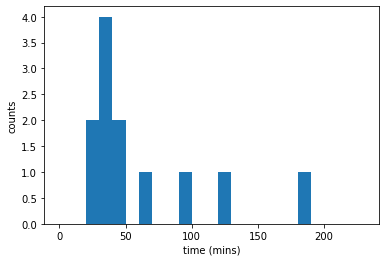

In [51]:
#When you go to a religious meeting, how much time do you spend there?
times = GetBetterTimes(data,["religious_time","religious_time_77" ])
religious_attendance_mean, religious_attendance_median = attendance(times)

In [52]:
religious_attendance_mean/60., religious_attendance_median/60.

(1.1891156462585035, 1.0)

Average over answers


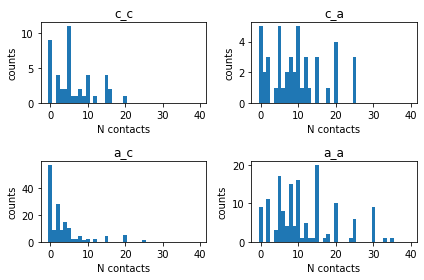

  religious:
    contacts: [[2.20,14.42],[0.88,16.02]]
    contacts_err: [[0.23,2.05],[0.10,1.18]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00

Average over answers per unit time


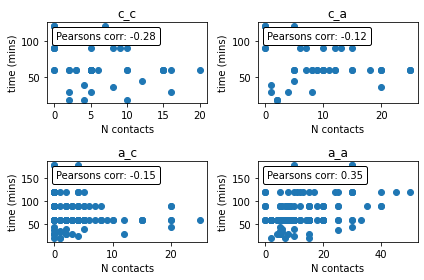

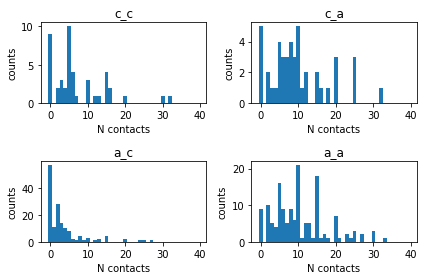

  religious:
    contacts: [[2.20,12.82],[0.88,16.02]]
    contacts_err: [[0.23,1.59],[0.11,1.10]]
    proportion_physical: [[0.12]]
    characteristic_time: 1.00


In [53]:
#"When you go to a religious meeting, approximately how many children do you come into contact with at the meeting (for example, talk to)?",
#"When you go to religious meeting, approximately how many adults do you come into contact with at the meeting (for example, talk to)?"
print("Average over answers")
religious_contact, religious_error = contact_matrix(
    data = data,
    x = "religious_contact_children",
    y = "religious_contact_adults",
    times = np.array(times)
)

religious_contact, religious_error = ModifyCM(religious_contact, religious_error , Nij)
PolicyText("religious", religious_contact, religious_error, np.array([[0.12]]), religious_attendance_median/60.)

print("")
print("Average over answers per unit time")

religious_contact, religious_error = contact_matrix(
    data = data,
    x = "religious_contact_children",
    y = "religious_contact_adults",
    times = np.array(times),
    norm = True, characteristic_time=religious_attendance_median
)
religious_contact, religious_error = ModifyCM(religious_contact, religious_error , Nij)
PolicyText("religious", religious_contact, religious_error, np.array([[0.12]]), religious_attendance_median/60.)

## Hand pump and latrine

In [54]:
Nij=np.unique(data[(data["pump_children"] != None) ]["age"], return_counts=True)
print(Nij)
Nij = np.array([Nij[1][2], Nij[1][0]+Nij[1][1]])
print(Nij)

(array(['Over 18 but under 60', 'Over 60', 'Under 18'], dtype=object), array([115, 102,  92]))
[ 92 217]


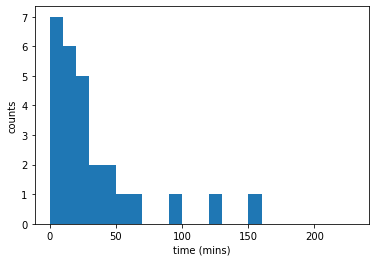

In [55]:
#When you go to a water pump or latrine, how much time do you spend there?
times = GetBetterTimes(data,["pump_time","pump_time77" ])
pump_latrine_attendance_mean, pump_latrine_attendance_median = attendance(times)

In [56]:
pump_latrine_attendance_mean/60., pump_latrine_attendance_median/60. 

(0.7146825396825397, 0.5416666666666666)

Average over answers


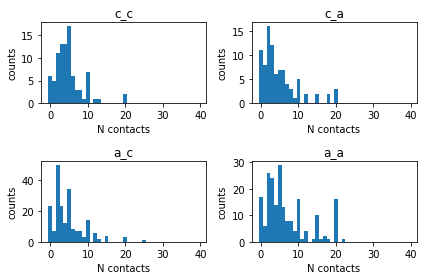

  pump_latrine:
    contacts: [[2.30,4.37],[1.72,7.29]]
    contacts_err: [[0.26,0.84],[0.31,0.30]]
    proportion_physical: [[0.02]]
    characteristic_time: 0.54

Average over answers per unit time


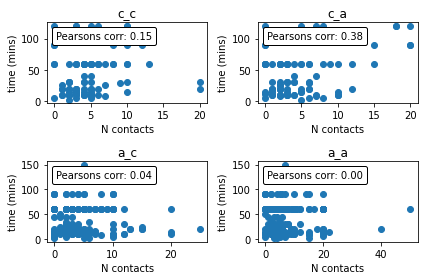

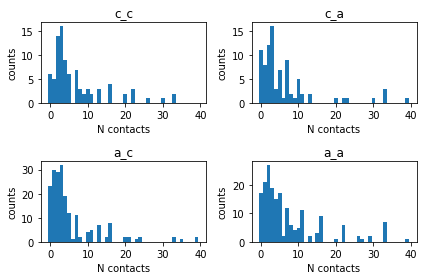

  pump_latrine:
    contacts: [[2.49,4.74],[1.76,7.11]]
    contacts_err: [[0.34,0.96],[0.17,0.75]]
    proportion_physical: [[0.02]]
    characteristic_time: 0.54


In [57]:
#"When you go to a water pump or latrine, approximately how many children do you come into contact with(for example, talk to)?",
#"When you go to water pump or latrine, approximately how many adults do you come into contact with(for example, talk to)?"
print("Average over answers")
pump_latrine_contact, pump_latrine_error = contact_matrix(
    data = data,
    x = "pump_children",
    y = "pump_adults",
    times = np.array(times)
)

pump_latrine_contact, pump_latrine_error = ModifyCM(pump_latrine_contact, pump_latrine_error , Nij)
PolicyText("pump_latrine", pump_latrine_contact, pump_latrine_error, np.array([[0.02]]), pump_latrine_attendance_median/60.)


print("")
print("Average over answers per unit time")
pump_latrine_contact, pump_latrine_error = contact_matrix(
    data = data,
    x = "pump_children",
    y = "pump_adults",
    times = np.array(times),
    norm = True, characteristic_time=pump_latrine_attendance_median
)
pump_latrine_contact, pump_latrine_error = ModifyCM(pump_latrine_contact, pump_latrine_error , Nij)
PolicyText("pump_latrine", pump_latrine_contact, pump_latrine_error, np.array([[0.02]]), pump_latrine_attendance_median/60.)